In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

Plan: Check the correlation between companies: Amazon, Microsoft, Google

Check correlation between Nvidia, AMD, Intel

daily return, correlation, moving average, risk level

In [37]:
cpu_list = ['NVDA', 'INTC','AMD']

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [38]:
for stock in cpu_list:
    globals()[stock] = yf.download(stock, start, end)

df_nvda = globals()['NVDA']
df_amd = globals()['AMD']
df_intc = globals()['INTC']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [39]:
window_size = 60

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

## Analysis

In [40]:
df_nvda.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

### Closing Prices

In [41]:
col_nvda = df_nvda['Adj Close']
col_amd = df_amd['Adj Close']
col_intc = df_intc['Adj Close']

col_df = pd.concat([col_nvda,col_amd,col_intc], axis=1)
col_df.columns = ['NVDA', 'AMD', 'INTC']

#### Performance Summary

In [42]:
fig = px.line(col_df, y=['NVDA','AMD','INTC'], title='Closing Prices of Stocks')
fig.show()

To be seen in the chart above, Nvidia's stock performance feels unnatural considering the stock performance of chipmaker companies. There is a possibility that Nvidia's stock may drop once it reaches the 1k dollar peak considering how close it is.

#### Individual Performance

In [43]:
fig_nvda = px.line(df_nvda, y=['Adj Close'], title='Nvidia Stock Performance')

fig_amd = px.line(df_amd, y=['Adj Close'], title='AMD Stock Performance')

fig_intc = px.line(df_intc, y=['Adj Close'], title='Intel Stock Performance')

In [44]:
fig_nvda.show()
fig_amd.show()
fig_intc.show()

It can be seen that there are certain drops in stock price for each company on the same day. Such as March 7th 2024, where each stock had its price experience a suddden spike in the semiconductor industry when Broadcom (AVGO) had its price target raised. 

It can be noticed that any annoucement in the industry can deeply affect other stock prices.

### Simple Moving Average (SMA)

Moving Average is used to smooth out the price data by creating an updated average price. Allowing us to see if the stock is going below the average due to fluctuations or random impacts in a certain time frame.

100 days can be used to represent a smaller price compared to the rest of the year. 

50 days represent a level that the stock is best to go under. 

10 days represent a close following of the stock and capture trends.

In [49]:
ma_day = [10, 50, 100]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_nvda[column_name] = df_nvda['Adj Close'].rolling(ma).mean()
    df_amd[column_name] = df_amd['Adj Close'].rolling(ma).mean()
    df_intc[column_name] = df_intc['Adj Close'].rolling(ma).mean()


Text(0.5, 1.0, 'Intel Moving Average')

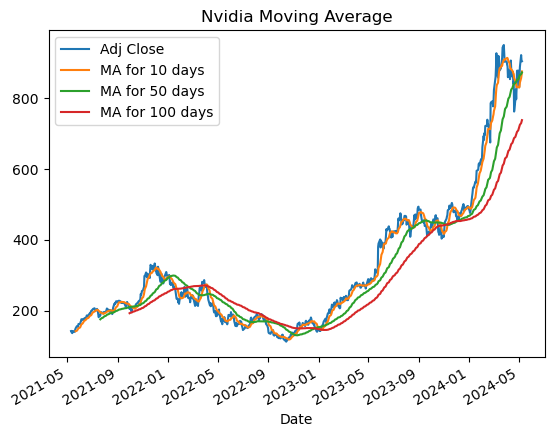

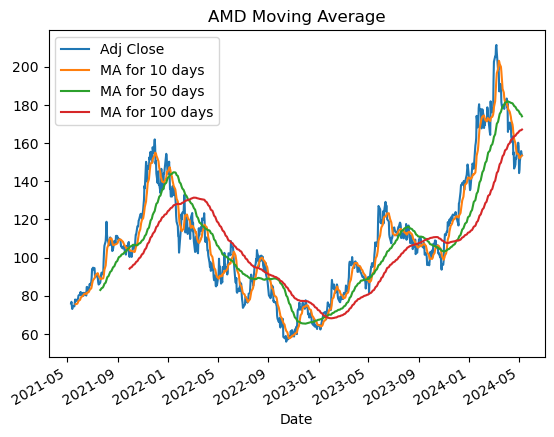

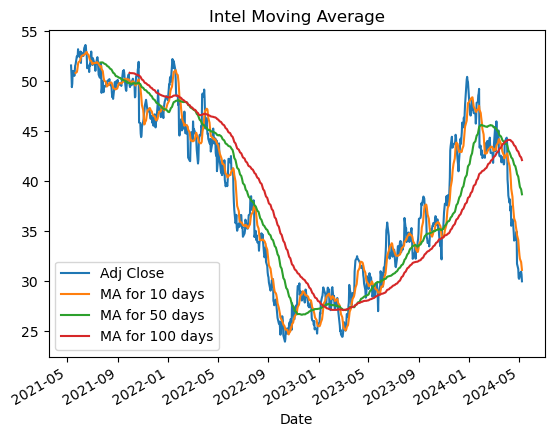

In [50]:
df_nvda[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Nvidia Moving Average")

df_amd[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("AMD Moving Average")

df_intc[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot()
plt.title("Intel Moving Average")

### Volatility Calculation

Volatility Calculation measures the change in variance in a stock's return. This can be used to compare the level of risk for stocks and comparison.

### Risk Level

## Conlcusion

When analyzing the correlation between the three stocks and their performance, Nvidia is no longer a good choice for futher investment considering its ever increasing price. A return in investment would be seen but consideirng its unnatural rise and how close it is to reaching $1000 dollars, there is a possibility that most would sell and thus causing the stock to drop to a more investable level. 

AMD and Intel are not as well performing as compared to Nvidia but hold a more reasonable price and promise. 